![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

# Grupo 23 | Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

**Integrantes:**
- Laura Camila Peralta Rivera
- Juan David Roldán Ruíz
- Jairo Rueda
- Diego Andrés García Montaño

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [68]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [78]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from math import sqrt



In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()*2 + (1 - y.mean())*2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])   
    best_split = [0, 0, 0]  # j, split, gain
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)           
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree 
    # Verificar si los nodos hijos no son nulos
    if 'sl' in tree and 'sr' in tree:
        if tree['sl'] is not None and tree['sr'] is not None:
            if tree['sl']['n_samples'] + tree['sr']['n_samples'] < 6:  # Verificar el número mínimo de nodos finales
                return tree
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']    
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X_train, y_train, 5)

# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)

# Ejecución de función tree_predict
tree_predict(X_test, tree)

array([1., 1., 1., ..., 1., 1., 1.])

In [85]:
mse = mean_squared_error(y_test,tree_predict(X_test, tree))
print("RMSE del Arbol calculado Manualmente es: ",sqrt(mse))

mae = mean_absolute_error(y_test,tree_predict(X_test, tree))

print("Mean Absolute error del Arbol calculado Manualmente es: ",  mae)

RMSE del Arbol calculado Manualmente es:  15113.767253661932
Mean Absolute error del Arbol calculado Manualmente es:  14598.966224018475


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [56]:
# Celda 2

# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)

# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, :]
    y_train = y_train.iloc[sample]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)

# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

# Error al promediar las predicciones de todos los árboles
print("Error al promediar las predicciones ",np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1))))


Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2094.921651442501
Árbol  2 tiene un error:  2143.588943820465
Árbol  3 tiene un error:  2091.5765590558344
Árbol  4 tiene un error:  2101.269034680839
Árbol  5 tiene un error:  2166.1579741770674
Árbol  6 tiene un error:  2167.965320861841
Árbol  7 tiene un error:  2160.523932246401
Árbol  8 tiene un error:  2160.7735197631982
Árbol  9 tiene un error:  2133.42356958019
Error al promediar las predicciones  1862.899085321319


Inicialmente, se crea un arreglo de 1 a 20, para luego crear las 10 muestras de bootstrap. Así mismo, se construyen y entrenan 10 árboles con las 10 muestras, y se generan las predicciones sobre los datos de test. Finalmente, se evalúa el desempeño de cada árbol mediante la métrica MSE y se compara con el MSE promedio de las predicciones de todos los árboles.

Se observa que el error MSE del ensamblaje de árboles es menor al error de cada árbol individualmente. De forma que se concluye que el ensamblaje bagging presenta mejor desempeño, que los modelos de árbol de decisión por separado.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [57]:
# Celda 3

from sklearn.ensemble import BaggingRegressor

n_features = X_train.shape[1]
max_features = int(np.log(n_features))

bagreg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=max_features), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

# Cálculo del error del modelo
print("MSE ",np.sqrt(mean_squared_error(y_test, y_pred)))

MSE  1995.7859168983287


Al entrenar el modelo bagging haciendo uso de BaggingRegressor de la librería sklearn, donde se usa el modelo DecisionTreeRegressor como estimador, y el parámetro max_features es igual a log(n_features), se obtiene un error MSE de 5520.23, que comparado con el desempeño del modelo bagging manual implementado en el punto anterior, se observa que desempeño inferior en el modelo de la librería, pues el error es más grande.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [61]:
# Celda 4 - Diego

#Librerías
#X_train, X_test, y_train, y_test

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de Regresión
rfr = RandomForestRegressor(random_state=1)

# Evaluamos el modelo utilizando la validación cruzada con 10 folds y el conjunto de datos completo
pd.Series(cross_val_score(rfr, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.802140
std       0.023024
min       0.765399
25%       0.789557
50%       0.801292
75%       0.822393
max       0.830908
dtype: float64

In [62]:
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

mse_m1 = mean_squared_error(y_test, y_pred)
r2_m1 = r2_score(y_test, y_pred)

print("MSE:", mse_m1)
print("R2:", r2_m1)

MSE: 3083089.1739264703
R2: 0.79844012886049


La evaluación del modelo de RandomForestRegressor a través de la validación cruzada de 10 folds ha dado una puntuación media de 0.801924 y una desviación estándar de 0.022742.

El valor máximo de la puntuación obtenida es de 0.831345 y el valor mínimo es de 0.765083. Los cuartiles muestran que el 25% de los puntajes se encuentran en el rango entre 0.765083 y  0.789707, mientras que el 50% de los puntajes están en el rango entre  0.789707 y 0.801237 y el 75% de los puntajes se encuentran en el rango entre 0.801237 y 0.821432.

En general, se puede concluir que el modelotiene un desempeño bastante bueno, ya que la puntuación media es alta y la desviación estándar es relativamente baja. Además, la diferencia entre la puntuación máxima y mínima no es demasiado grande, lo que indica que el modelo tiene una consistencia razonable en su rendimiento.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

####Calibración de n_estimators

El mejor valor de n_estimators es: 120
MSE en conjunto de prueba con mejor valor de n_estimators:  3081308.333607352
r2 en conjunto de prueba con mejor valor de n_estimators:  0.7985565529809069


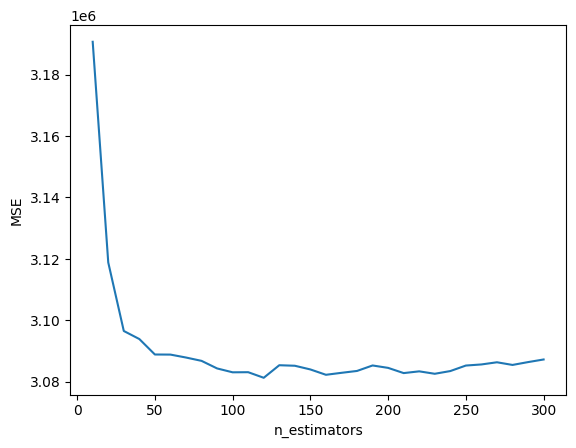

In [63]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rfr = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

# Seleccionar el mejor valor de n_estimators
best_n_estimators = estimator_range[np.argmin(mse_scores)]
print("El mejor valor de n_estimators es:", best_n_estimators)


rfr = RandomForestRegressor(n_estimators=best_n_estimators, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = rfr.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_m2 = mean_squared_error(y_test, y_pred)
r2_m2 = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de n_estimators: ", mse_m2)
print("r2 en conjunto de prueba con mejor valor de n_estimators: ", r2_m2)

Este parámetro indica el número de árboles de decisión que se crearán en el Random Forest. Un valor mayor de n_estimators puede mejorar el rendimiento del modelo, pero también puede aumentar el tiempo de entrenamiento y la complejidad del modelo, por este motivo hemos decidido escoger como valor para el parametro el 120 debido a que un numero mayor a este no representa una mejoría considerable en la precisión del modelo. este punto representa el equilibrio ideal entre el rendimiento del modelo y el costo computacional.

El valor del mse y r2 en este punto óptimo es de 3081308.33 y 0.7985 respectivamente, lo cual presenta una mejoría considerable con respecto al modelo inicial.



####Calibracióm max_features

El mejor valor de max_features es: 9
MSE en conjunto de prueba con mejor valor de max_features:  3081308.333607352
r2 en conjunto de prueba con mejor valor de max_features:  0.7985565529809069


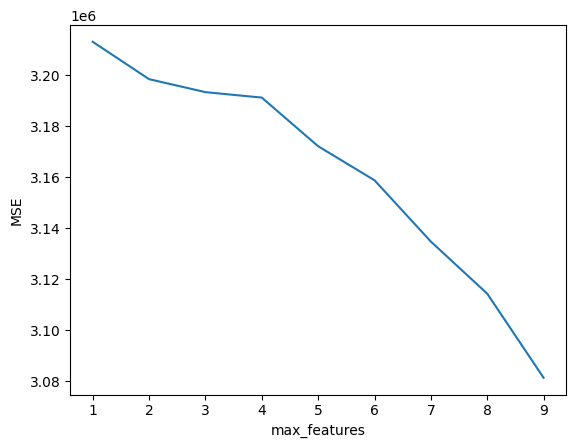

In [64]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rfr = RandomForestRegressor(n_estimators=120, max_features=feature, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mse_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

# Seleccionar el mejor valor de max_features
best_max_features = feature_range[np.argmin(mse_scores)]
print("El mejor valor de max_features es:", best_max_features)

rfr = RandomForestRegressor(n_estimators=120, max_features=best_max_features, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = rfr.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_m3 = mean_squared_error(y_test, y_pred)
r2_m3 = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de max_features: ", mse_m3)
print("r2 en conjunto de prueba con mejor valor de max_features: ", r2_m3)

En el modelo de RandomForestRegressor, max_features parámetro que determina el número máximo de variables que se considerarán al buscar la mejor división en cada nodo del árbol de decisión. Un valor bajo de max_features puede aumentar la varianza del modelo y el riesgo de sobreajuste, ya que solo se consideran un pequeño subconjunto de las características en cada árbol de decisión. Sin embargo, esto también puede hacer que el modelo sea más robusto a características irrelevantes. Para este Dataset con el que estamos trabajando utlizaremos las 9 variables con las que contamos, por ende el valor que tomará este parámetro en el modelo óptimo será 9.

El valor del mse y r2 en este punto óptimo es de 3081308.33 y 0.7985 respectivamente, lo cual presenta una mejoría considerable con respecto al modelo inicial sin calibrar.


####Calibración max_depth

El mejor valor de max_depth es: 8
MSE en conjunto de prueba con mejor valor de max_depth:  2447183.338843247
r2 en conjunto de prueba con mejor valor de max_depth:  0.8400130743530143


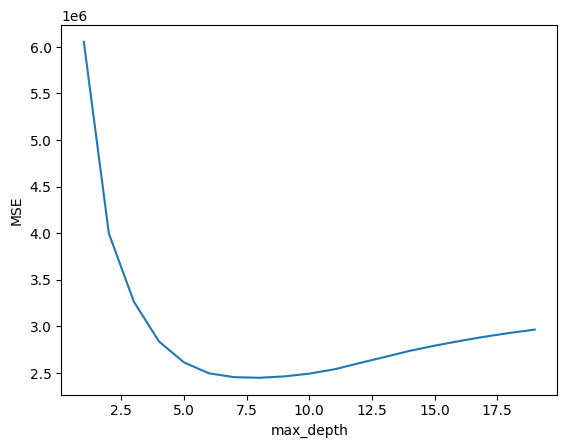

In [65]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = np.arange(1, 20)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rfr = RandomForestRegressor(n_estimators=120, max_features=9, max_depth = depth,random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))


# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

# Seleccionar el mejor valor de max_depth
best_max_depth = depth_range[np.argmin(mse_scores)]
print("El mejor valor de max_depth es:", best_max_depth)

rfr = RandomForestRegressor(n_estimators=120, max_features=9, max_depth= best_max_depth , random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = rfr.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_m4 = mean_squared_error(y_test, y_pred)
r2_m4 = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de max_depth: ", mse_m4)
print("r2 en conjunto de prueba con mejor valor de max_depth: ", r2_m4)

Una profundidad máxima más alta significa que los árboles pueden ser más complejos y pueden capturar patrones más finos en los datos, pero también puede aumentar el riesgo de sobreajuste.

Si la profundidad máxima es demasiado baja, los árboles pueden no ser lo suficientemente profundos para capturar patrones importantes en los datos, lo que puede llevar a un desempeño deficiente en el conjunto de datos de prueba. Por otro lado, si la profundidad máxima es demasiado alta, el modelo puede sobreajustarse al conjunto de datos de entrenamiento y no generalizar bien a nuevos datos.

para este caso, el valor óptimo del parametro max_depth será de 8, ya que este nos brinda un MSE de 2447183.33 y un r2 de 0.84, considerablemente mucho mayor que el modelo inicial.

####Modelo Óptimo




MSE: 2447183.338843247
R2: 0.8400130743530143


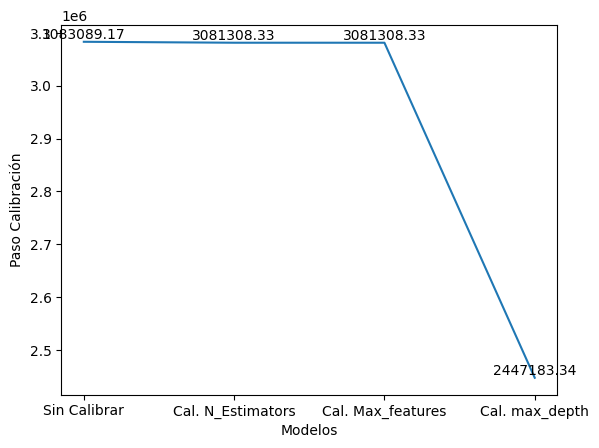

In [66]:
# Definición del modelo óptimo

rfr = RandomForestRegressor(n_estimators=120, max_features=9, max_depth= 8 , random_state=1, n_jobs=-1)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)

mse_modelos = [mse_m1, mse_m2, mse_m3, mse_m4]
modelos = ["Sin Calibrar", "Cal. N_Estimators", "Cal. Max_features", "Cal. max_depth"]

plt.plot(modelos, mse_modelos)
plt.ylabel('Paso Calibración')
plt.xlabel('Modelos')

for i in range(len(modelos)):
    plt.text(modelos[i], mse_modelos[i], str(round(mse_modelos[i], 2)), ha='center', va='bottom')

plt.show()

Con base en los resultados obtenidos al evaluar el desempeño de cada uno de los modelos que hicieron parte del proceso de calibración, podemos concluir que el proceso de calibración es crucial para obtener un modelo con un alto poder predictivo. Al ir definiendo los valores óptimos de los parámetros del modelo, se evidenció una mejoría en su desempeño, pero fue la calibración del parámetro "max_depth" la que produjo la mayor mejora en el valor del MSE y el aumento del valor del R2 del modelo.

Estos resultados nos muestran la importancia de cada parámetro en el desempeño del modelo y cómo su ajuste afecta la forma en que el modelo se ajusta a los datos. Al final del proceso de calibración, se obtuvo un modelo final con un MSE de 2447183.33 y un R2 de 0.84, lo cual indica que es un modelo con un alto poder predictivo y que puede ser utilizado para hacer predicciones precisas sobre los datos. En resumen, la calibración de los parámetros es una parte fundamental del entrenamiento de un modelo y puede marcar la diferencia en su desempeño final.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [70]:
# Celda 6

clf = XGBRegressor()
print(clf)
# Entrenamiento (fit) y desempeño del modelo XGBoost
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"El MSE del modelo es: {mean_squared_error(y_test, y_pred)}")
print(f"El R2 del modelo es: {r2_score(y_test, y_pred)}")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
El MSE del modelo es: 2629001.844928506
El R2 del modelo es: 0.8281265175296673


Se calibra un modelo de regresión XGBoost a través de la librería sklearn con el fin de predecir el precio de los vehículos acorde a los diferentes predictores,

El modelo XGBoost, o extreme gradieng boosting es un método de aprendizaje automático supervisado para clasificación y regresión. Este método se basa en árboles de decisión y supone una mejora sobre otros métodos, como el bosque aleatorio y refuerzo de gradientes. Su funcionamiento se basa en el modelo de gradient boosting y funciona a través de entrenar diferentes weak learners a través de la función de gradiente descendiente la cual, iterativamente va prediciendo los errores del árbol anterior y así va mejorando el modelo, adicional utiliza muestreo aleatorio para las muestras de entrenamiento y los predictores, tiene mejoras algoritmicas y computacionales con respecto a gradient boosting, por lo que se llama coloquialmente un "gradient boosting con esteroides",

Se entrena el XGBoost de regresión para nuestro dataset con los hiperparámetros default obteniendo un MSE de 2629001.84

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

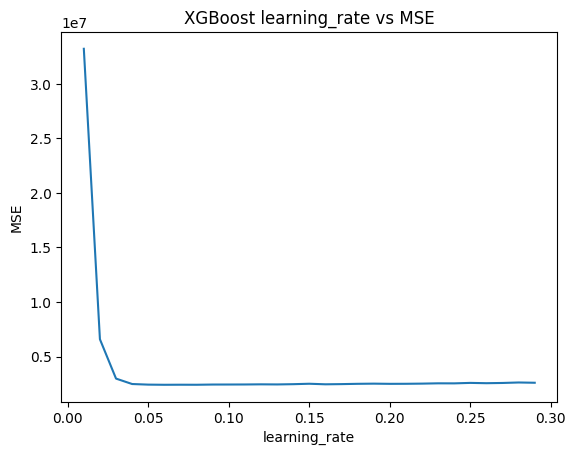

El mejor valor de learning_rate es: 0.060000000000000005
MSE en conjunto de prueba con mejor valor de learning_rate:  2418818.437107645
R2 en conjunto de prueba con mejor valor de learning_rate:  0.84186745663526


In [71]:
# Celda 7

#Calibración para learning rate

# Definir los diferentes valores de learning_rate que se van a probar
learning_rate = np.arange(0.01, 0.3, 0.01)
# Inicializar la lista donde se guardarán los resultados
medias = []
# Entrenar el modelo para cada valor de learning_rate y calcular el MSE
for i in learning_rate:
    clf = XGBRegressor(learning_rate=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    medias.append(mean_squared_error(y_test, y_pred))
# Graficar los resultados
plt.plot(learning_rate, medias)
plt.title("XGBoost learning_rate vs MSE")
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()
# Seleccionar el mejor valor de learning_rate
best_learning_rate = learning_rate[np.argmin(medias)]
print("El mejor valor de learning_rate es:", best_learning_rate)
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado
clf = XGBRegressor(learning_rate=best_learning_rate)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate: ", mse_lr)
print("R2 en conjunto de prueba con mejor valor de learning_rate: ", r2_lr)


El mejor valor de gamma es: 0.1


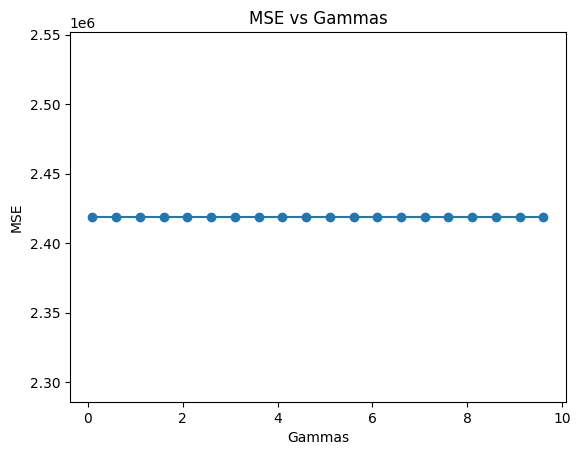

MSE en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es:  2418818.437107645
R2 en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es:  0.84186745663526


In [72]:
#Calibración del mejor gamma

# Definir los diferentes valores de gamma que se van a probar
gammas = np.arange(0.1, 10, 0.5)
# Entrenar modelos XGBoost con cada valor de gamma y calcular el MSE en el conjunto de prueba
mses = []
for gamma in gammas:
    clf = XGBRegressor(gamma=gamma,learning_rate=best_learning_rate)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)
# Encontrar el índice del valor de gamma con el MSE más bajo
best_gamma_idx = np.argmin(mses)
best_gamma = gammas[best_gamma_idx]
# Imprimir el valor de gamma con el MSE más bajo
print("El mejor valor de gamma es:", best_gamma)
# Graficar los resultados
plt.plot(gammas, mses, '-o')
plt.xlabel('Gammas')
plt.ylabel('MSE')
plt.title('MSE vs Gammas')
plt.show()
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado y el mejor gamma
clf = XGBRegressor(learning_rate=best_learning_rate, gamma = best_gamma)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_g = mean_squared_error(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es: ", mse_g)  
r2_g = r2_score(y_test, y_pred)
print("R2 en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es: ", r2_g)

El mejor valor de colsample_bytree es: 0.44999999999999984


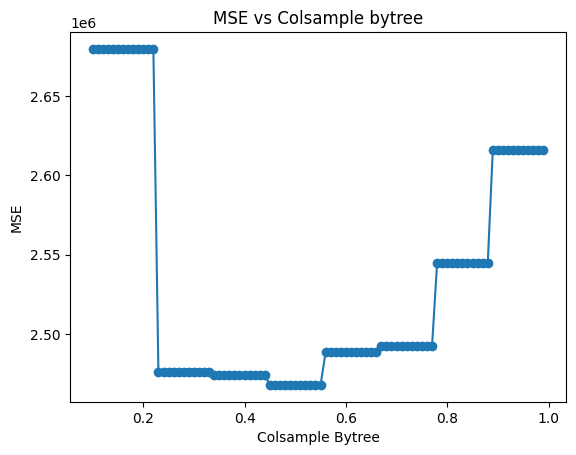

MSE en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es:  2399066.6539287544
R2 en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es:  0.8431587481444325


In [73]:
#Calibración del mejor colsample_bytree

# Definir los diferentes valores de colsample_bytree que se van a probar
colsamples = np.arange(0.1, 1, 0.01)
# Entrenar modelos XGBoost con cada valor de colsample_bytree y calcular el MSE en el conjunto de prueba
mses = []
for colsample in colsamples:
    clf = XGBRegressor(colsample_bytree=colsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)
# Encontrar el índice del valor de colsample_bytree con el MSE más bajo
best_colsample_idx = np.argmin(mses)
best_colsample = colsamples[best_colsample_idx]
# Imprimir el valor de colsample_bytree con el MSE más bajo
print("El mejor valor de colsample_bytree es:", best_colsample)
# Graficar los resultados
plt.plot(colsamples, mses, '-o')
#plt.xscale('log')
plt.xlabel('Colsample Bytree')
plt.ylabel('MSE')
plt.title('MSE vs Colsample bytree')
plt.show()
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado y el mejor gamma
clf = XGBRegressor(learning_rate=best_learning_rate, gamma = best_gamma, colsample_bytree = best_colsample)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_CST = mean_squared_error(y_test, y_pred)
r2_CST = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es: ", mse_CST)
print("R2 en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es: ", r2_CST)

In [74]:
print(best_learning_rate)
print(best_gamma)
print(best_colsample)

0.060000000000000005
0.1
0.44999999999999984


Luego de entrenar el modelo de regresión XGBoosting con sus hiperparámetros por default, se procede a calibrar los parámetros learning rate, gamma y colsample_bytree para intentar obtener un mejor desempeño en el modelo.

Se comienza con el learning rate, ya que el algoritmo utiliza el aprendizaje lento o boosting como base, el learning rate se encarga de asignar un peso a la tasa de aprendizaje, con el fin de evitar el sobreajuste, normalmente se toman valores entre 0.01 y 0.3 para este hiperparámetro por lo que se crea un rango con saltos de 0.01 entre estos dos valores y se entrena un modelo XGBoost de regresión 29 veces para cada una de las opciones, se almacena el MSE en cada una de las iteraciones para evaluar el performance de los 29 modelos y así determinar cual es el mejor. Luego de hacer el loop y la evaluación se determina que el mejor learning rate es el de 0.06, este causa una mejora en el modelo con los hiperparámetros originales obteniendo un nuevo MSE de 2418818.43.

Como segundo paso se hace un procedimiento similar al del learning rate pero ahora con el hiperparámetro “Gamma", el objetivo del hiperparámetro gamma es controlar la complejidad del modelo de regresión y prevenir el sobreajuste, ajustando la penalización de la función de costo para hojas con valores cercanos a cero. Normalmente se toman valores entre 0.1 y 10 para este hiperparámetro por lo que se crea un rango con saltos de 0.5 entre estos dos valores y se entrena un modelo XGBoost 20 veces para cada una de las opciones, se almacena el MSE en cada una de las iteraciones para evaluar el performance de los 20 modelos y así determinar cual es el mejor. Luego de hacer el loop y la evaluación se determina que el mejor Gamma es el de 0.1, este no causa una mejora en el modelo con los hiperparámetros anteriores ya que el MSE obtenido sigue siendo de 2418818.43.

Como tercer y último paso, se hace el mismo procedimiento pero ahora con el hiperparámetro “colsample_bytree ", el objetivo del hiperparámetro es controlar la proporción de características (columnas) que se seleccionan al construir cada árbol en el proceso de entrenamiento del modelo. Este hiperparámetro es específico para el algoritmo "Tree Boosting" que utiliza XGBoost. El propósito de colsample_bytree es controlar la varianza del modelo, permitiendo que cada árbol utilice solo una muestra aleatoria de las características disponibles en el conjunto de datos. Al hacer esto, se puede evitar que el modelo se ajuste en exceso a características específicas y permitir una mejor generalización. Normalmente se toman valores entre 0.1 y 1 para este hiperparámetro por lo que se crea un rango con saltos de 0.01 entre estos dos valores y se entrena un modelo XGBoost 90 veces para cada una de las opciones, se almacena el MSE en cada una de las iteraciones para evaluar el performance de los 90 modelos y así determinar cuál es el mejor. Luego de hacer el loop y la evaluación se determina que el mejor colsample_bytree es el de 0.339, este causa una mejora en el modelo, considerando la configuración de los hiperparámetros anteriores se tiene ahora un MSE de 2399066.65.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

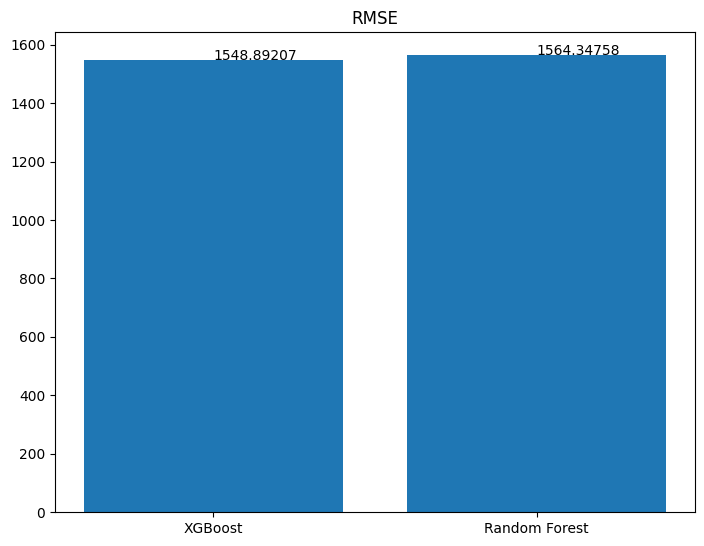

In [77]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("RMSE")
ejeX = ['XGBoost', 'Random Forest']
ejeY = [sqrt(mse_CST),sqrt(mse_m4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],round(y[i],5))
addlabels(ejeX,ejeY,plt)
plt.show()



Después de haber creado y ejecutado los modelos de predicción por los métodos tanto Random Forest como XGBoosting, nos encontramos que para poder estimar cual es el que estimaría de mejor manera la predicción del precio de un carro dadas las variables contenidas en la base de datos tales como, Marca, modelo, millaje, estado en el cual se encuentra ubicado, vamos a utilizar como métrica de decisión el RMSE (raíz del Error cuadrático medio) dado a la consistencia del estimador que a menor valor nos indica que el modelo presenta un mejor ajuste. Para este caso y como lo vimos en los puntos anteriores, como primer paso en búsqueda del mejor modelo para la predicción de los precios de los carros, se hizo las calibraciones específicas para cada tipo de modelo.

Las primeras calibraciones realizadas están relacionadas con la estimación del modelo de Landon Forest para las cuales se tuvieron: como resultado los siguientes valores asociados:

*   max_depth: 6
*   max_features: 5
*   n_estimators: 210

Dadas las calibraciones, y al haber sido ingresadas al modelo podemos notar que resulta un modelo con un MSE 2447183.33 y un RMSE 1564.34758.

De la misma forma, se calculó el modelo XGBoost, para saber que tan bueno sería prediciendo los precios de los carros, mediante el método de boosting, dado este parámetro, se tuvo en cuenta una predicción base y adicionalmente  se calculó calibrando los diferentes parámetros que ayudan a generar la mejor predicción, para esto y como se explicó en los puntos anteriores para el modelo de boosting, se calibraron:

*   learning_rate: 0.06
*   gamma: 0.1
*   colsample: 0.449

Como resultado de las calibraciones y ajustadas en el cálculo del modelo encontramos que para los estimadores resultantes el MSE 2399066.65 y el RMSE de 1548.89207.

Como lo podemos observar en la gráfica anterior, y dada la interpretación de los estimadores, al XGBoost tener un RMSE menor, nos indica que, con este modelo, los errores obtenidos en promedio del modelo son más bajos que los obtenidos en el Random Forest, por lo que los resultados predichos por parte del primer modelo van a ser o van a explicar de una mejor manera la predicción del precio de los carros dadas las condiciones especificadas.

De la misma forma, podemos asumir que el Random forest obtuvo un valor mayor en la media de sus errores cuadráticos por lo que si bien puede ser un modelo con alto valor predictivo, no supero la proximidad del otro.



